In [233]:
import numpy as np
import scipy.signal
import sounddevice as sd
%matplotlib inline
from pylab import *
import matplotlib.figure
import itertools
import random
import mpld3
mpld3.enable_notebook()
rcParams['figure.figsize'] = 10, 6
rcParams['figure.dpi'] = 90


In [234]:
def gauss_imp(BT, span, sample_rate):
    #num_coefficients is the sampling rate of the filter
    #3db_bandwidth is the 3db bandwidth of the gaussian filter
    #symbol time is the time difference between two symbols during transmission
    alph = np.sqrt(2. * np.pi / np.log(2)) * BT
    imp = np.linspace(- span * sample_rate / 2, span * sample_rate / 2, span*sample_rate)
    #generate coefficents
    imp *= np.sqrt(np.pi) * alph / sample_rate
    imp = - np.power(imp, 2)
    imp = np.exp(imp)
    imp *= alph
    imp /= sum(imp)
    return imp

def convolve(data, imp):
    out = []
    for a in range(len(data)):
        count = 0
        for i in range(len(imp)):
            if a - i >= 0:
                count += imp[i] * data[a - i]
        out.append(count)
    return np.array(out)

def periodic_data(num_symbols, num_samples):
    return  scipy.signal.square(
          np.linspace(0, num_symbols,
                      num_symbols * num_samples, endpoint=False)
          * np.pi)

def random_data(num_symbols, num_samples):
    arr = []
    for i in range(num_symbols):
        symb = random.randint(0, 1)
        for j in range(num_samples):
            arr.append(symb)
    return np.array(arr)

def GFSK_mod(carrier_freq, mod_index, mod_sample_rate, data, bit_rate, BT, span):
    total_time = len(data) / bit_rate
    
    time = np.linspace(0, total_time, total_time * mod_sample_rate)
    
    bit_span = mod_sample_rate/bit_rate
    
    sampled_data = np.repeat(data, bit_span)
    
    imp = gauss_imp(BT, span, bit_span)
    
    filtered_data = scipy.signal.convolve(sampled_data, imp, mode='same')
    
    
    plt.figure()
    plt.plot(filtered_data)
    plt.plot(sampled_data)
    plt.title('Filtered Data')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (V)')
    plt.show()
    
    return time, np.cos(2 * np.pi * carrier_freq * time + mod_index * filtered_data)


def transmit(signal):
    # signal is an np.array of the signal we are playing
    frames_per_second = 48000
    sd.play(data = signal, samplerate = fs, blocking = False)

[1 1 1 1 0 1 0 0]


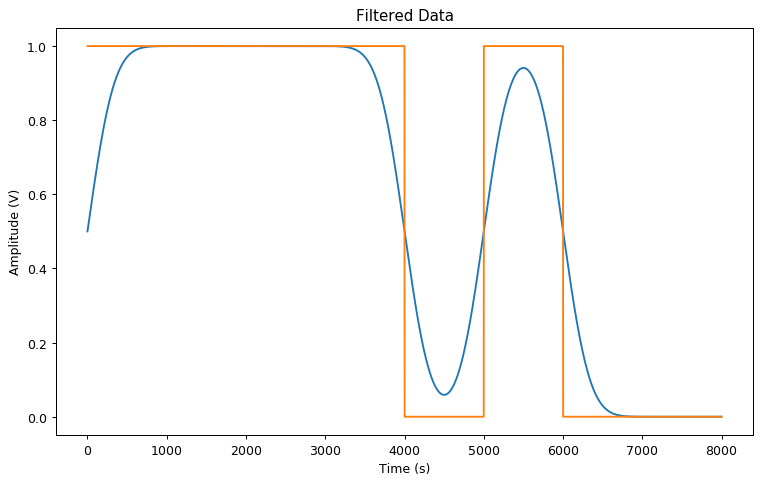

In [284]:
bit_rate = 10
BT = 0.5
fc = 1000
mod_index = 20
mod_sample_rate = 1e4
span = 2

period_data = np.array([random.randint(0, 1) for i in range(8)])
print(period_data)

# GFSK_mod(carrier_freq, mod_index, mod_sample_rate, data, bit_rate, BT, span):
_,test_signal = GFSK_mod(fc, mod_index, mod_sample_rate, period_data, bit_rate, BT, span)

(800, 1200)

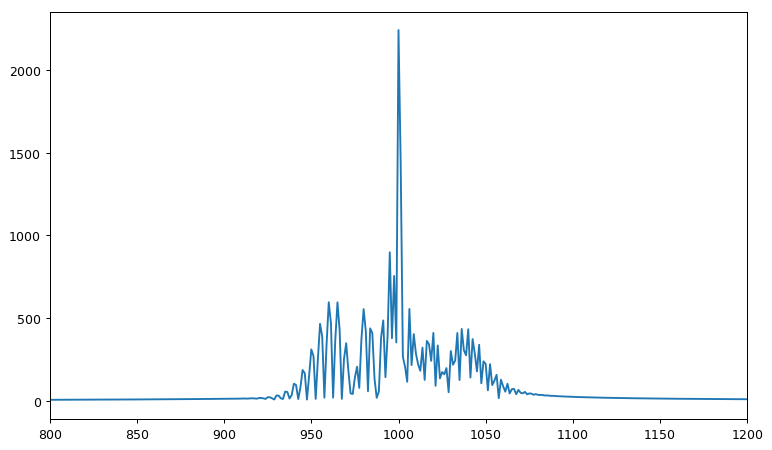

In [285]:
plt.figure()
test_signal_fft = np.abs(np.fft.fftshift(np.fft.fft(test_signal)))
plt.plot(sorted(np.fft.fftfreq(len(test_signal_fft), 1./mod_sample_rate)),test_signal_fft)
plt.xlim([800, 1200])

array([1, 1, 1, 0, 1, 0, 0, 0])

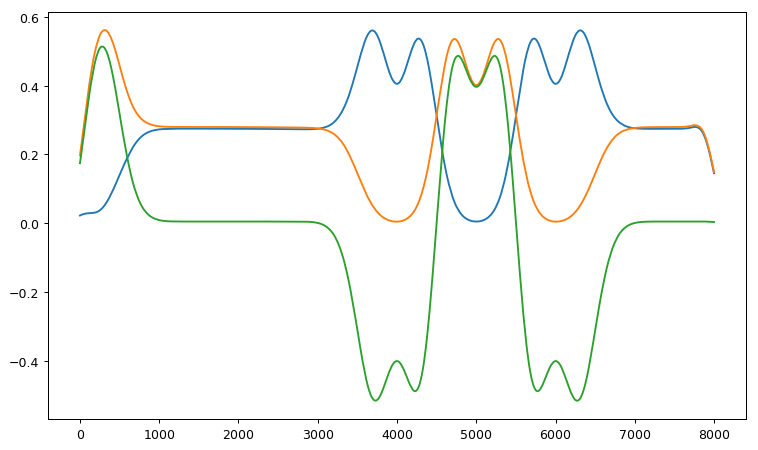

In [288]:
CARRIER_FREQUENCY_HIGH = 1025
CARRIER_FREQUENCY_LOW = 975

CARRIER_FILTER_HALF_SPACE = 20

INPUT_SAMPLE_RATE = mod_sample_rate

WINDOW_FILTER_RESOLUTION = 511

ENVELOPE_RESOLUTION = 511

LOW_PASS_RES = 127

DATA_RATE = bit_rate

DATA_FILTER = scipy.signal.firwin(LOW_PASS_RES, (CARRIER_FREQUENCY_HIGH + 100.) / INPUT_SAMPLE_RATE, pass_zero=False)

WIND_FIR_LOW = scipy.signal.firwin(WINDOW_FILTER_RESOLUTION, 
                                    [(CARRIER_FREQUENCY_LOW - CARRIER_FILTER_HALF_SPACE) * 2/ INPUT_SAMPLE_RATE, 
                                     (CARRIER_FREQUENCY_LOW + CARRIER_FILTER_HALF_SPACE) * 2/ INPUT_SAMPLE_RATE], pass_zero=False)

WIND_FIR_HIGH = scipy.signal.firwin(WINDOW_FILTER_RESOLUTION, 
                                    [(CARRIER_FREQUENCY_HIGH - CARRIER_FILTER_HALF_SPACE) * 2/ INPUT_SAMPLE_RATE, 
                                     (CARRIER_FREQUENCY_HIGH + CARRIER_FILTER_HALF_SPACE) * 2/ INPUT_SAMPLE_RATE], pass_zero=False)

ENVELOPE_COEFF = scipy.signal.firwin(ENVELOPE_RESOLUTION, DATA_RATE / INPUT_SAMPLE_RATE)

def bit_detection(input_data, start_sequence, bit_rate, sample_rate):
    input_data = scipy.signal.convolve(input_data, DATA_FILTER, mode='same')
    
    low_filtered = np.abs(scipy.signal.convolve(input_data, WIND_FIR_LOW, mode='same'))
    high_filtered = np.abs(scipy.signal.convolve(input_data, WIND_FIR_HIGH, mode='same'))
    
    envelope_low = scipy.signal.convolve(low_filtered, ENVELOPE_COEFF, mode='same')
    envelope_high = scipy.signal.convolve(high_filtered, ENVELOPE_COEFF, mode='same')
    
    recovered_data = envelope_high - envelope_low
    
    plt.figure()
    plt.plot(envelope_low)
    plt.plot(envelope_high)
    plt.plot(recovered_data)

    recovered_bits = [0]
    
    for bit in (recovered_data):
        if recovered_bits[-1] == 1 and bit < -0.01:
            recovered_bits.append(0)
        elif recovered_bits[-1] == 0 and bit > 0.01:
            recovered_bits.append(1)
        else:
            recovered_bits.append(recovered_bits[-1])
    
    bits = np.array(recovered_bits)
    
    first_switch = -1
    for i in range(len(recovered_bits) - 1):
        if bits[i] != bits[i + 1]:
            first_switch = i
            break
            
    #plt.plot(recovered_bits)
    sampler = np.arange(first_switch + mod_sample_rate * .1, len(recovered_bits), sample_rate / bit_rate)
    
    return bits[sampler.astype(int)]

bit_detection(test_signal, [], bit_rate, mod_sample_rate)

array([1, 1, 1, 0, 1, 0, 0])

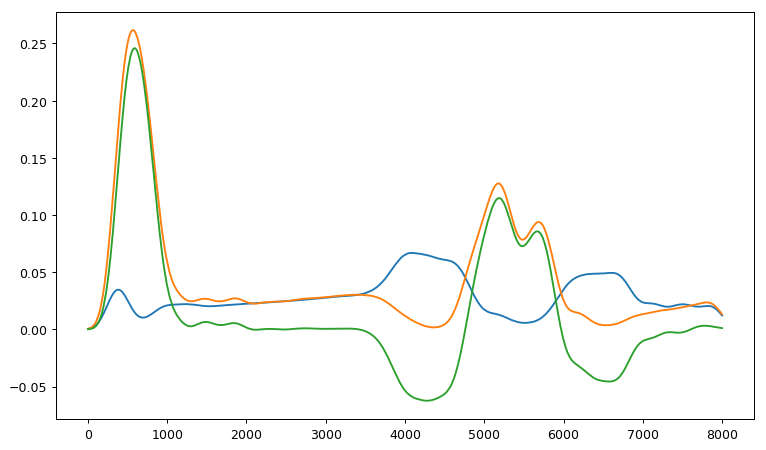

In [289]:
recording = sd.playrec(test_signal, samplerate = INPUT_SAMPLE_RATE, channels=1, blocking=True)
sd.play(recording, samplerate = INPUT_SAMPLE_RATE)

bit_detection(recording.ravel(), [], DATA_RATE, INPUT_SAMPLE_RATE)